In [1]:
!pwd

/home/sebastian/Computing/GeMSE/results/2025-10-07_LowRad_PMTBases_Resistors_Glue/notebooks


# Definitions

In [2]:
import uproot
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pprint import pprint

In [3]:
plt.style.use("/home/sebastian/.pltstyle/gemse_small.mplstyle")

In [4]:
def readTree(fns, offsets, branch_names=["Channel", "Timestamp", "Board", "Energy", "Flags"], tree_name='Data_R'):
    assert len(fns) == len(offsets)
    nEntries_tot = 0
    data = {}
    for i in range(len(fns)):
        fn = fns[i]
        o  = offsets[i]
        print (f"Processing run {i+1}/{len(fns)}, offset by {o/1e12/(24*3600):.2} days")
        with uproot.open(fn) as file:
            tree = file[tree_name]
            for bn in branch_names:
                offset = 0
                if bn == "Timestamp":
                    offset = o
                    nEntries = len(tree[bn].array(library="np"))
                    nEntries_tot += nEntries
                    print (f"  ... {offset=}; {nEntries=}")
                if bn in data: #.keys():
                    data[bn] = np.append( data[bn], tree[bn].array(library="np")+offset )
                    print ('appending...')
                else:
                    data[bn] = tree[bn].array(library="np")+offset
                    #print ('NOT appending...')
    print (f"Total number of Entries: {nEntries_tot}")
    return data

In [5]:
def simple_rate(data, info, ADCrange):
    t0 = info["tstart_datetime"]
    t1 = info["tstop_datetime"]
    dt=t1-t0
    dts = (dt).total_seconds()
    print (f"The run lasted {dt} ({dts} seconds)")
    Xadc = ((data>ADCrange[0])&(data<ADCrange[1]))
    #ncounts = np.sum(data[Xadc])
    ncounts = len( data[Xadc] )
    #pprint (data[Xadc])
    print (f"Total number of counts in range [{ADCrange[0]},{ADCrange[1]}]: {ncounts:.3e}")
    r = ncounts/dts
    re =np.sqrt(ncounts)/dts
    print (f"  ->  {r:.3f}+-{re:.3f}")
    return (r, re, ncounts, dts)

In [6]:
def myhist(data, erange, label, alpha, xaxis="keV", sumbins=10.):
    # 0. transform erange to adcrange
    # 1. compute proper number of bins nb
    # 2. bin data e.g. using np.histogram and nb bins
    # 3. compute bin_edges_kev from bin_edges_adc
    # 4. plot histogram using bin_edges_kev
    erange=np.array(erange)
    adcrange = keV2ADC(erange)
    nb = round ( (adcrange[1]-adcrange[0]+1)/sumbins ) 
    _n_adc, _bin_edges_adc = np.histogram(data, bins=nb, range=adcrange) # do histogram in ADC space

    if xaxis == "ADC":
        _n, _be, _p = plt.gca().hist(_bin_edges_adc[:-1], _bin_edges_adc, weights=_n_adc, alpha=alpha, label=label)
    elif xaxis == "keV":
        _bin_edges_keV = ADC2keV(_bin_edges_adc)
        _bin_width = np.diff(_bin_edges_keV)
        _n, _be, _p = plt.gca().hist(_bin_edges_keV[:-1], _bin_edges_keV, weights=_n_adc/_bin_width, alpha=alpha, label=label)
    else:
        print ("Error. Only keywords 'keV' or 'ADC' allowed for xaxis parameter!")
        assert 1 == 0
    
    return _n, _be, _p

In [7]:
def plot_hist_flags(data, erange=(0,17000), fig=None, ax=None, verbose=False, n_drawonly=-1, 
                    alpha=1, sumbins=10., title=None, fout=None, xaxis="keV", drawline=None):
    flags = list( np.unique ( data["Flags"] ) )

    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize = (12,6))

    El = erange[0]
    Eh = erange[1]
    nb = round( (Eh-El+1)/sumbins )
    
    Xfa = []
    N = []
    
    for fl in flags:
        Xfa.append( data["Flags"]==fl )
        n_events = len( data["Energy"][Xfa[-1]] )
        N.append(n_events)
    
    Nsi = np.argsort(N)
    
    for _n in Nsi[::-1]:
        fl = flags[_n]
        n_events = N[_n]
        Xf = Xfa[_n]
        if n_events>n_drawonly:
            if verbose:
                print (f"{hex(fl)} ({fl}) -> {n_events=}") 
            if xaxis=="ADC":
                ax.hist(data["Energy"][Xf], bins=nb, range=(El,Eh), label=f"{hex(fl)}", alpha=alpha)
            elif xaxis=="keV":
                myhist(data=data["Energy"][Xf], erange=(El,Eh), label=f"{hex(fl)}", alpha=alpha, xaxis=xaxis, sumbins=sumbins)
        else:
            if verbose:
                print (f"{hex(fl)} ({fl}) -> {n_events=}  (suppressing the plotting)") 
    
    ax.set_yscale("log")
    if xaxis=="ADC":
        ax.set_ylabel("Events/bin / 1/ADC")
        ax.set_xlabel("Energy / ADC")
    elif xaxis=="keV":
        ax.set_ylabel("Events/bin / 1/keV")
        ax.set_xlabel("Energy / keV")
        
    if title:
        ax.legend(title=title)
    else:
        ax.legend()

    if not drawline is None:
        ax.axvline(x=float(drawline), ls='--', lw=1, color='k')
    if not fout is None:
        fig.savefig(fout)
    fig.show()

In [8]:
# Define the Gaussian function
def gaussian(x, amp, mean, stddev, offset):
    return offset + amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

def gbc(bins):
    """
    Compute the bin centers from the bin edges.

    Parameters:
    bins (array-like): The edges of the bins returned by plt.hist.

    Returns:
    np.ndarray: The centers of the bins.
    """
    return 0.5 * (bins[:-1] + bins[1:])


from scipy.optimize import curve_fit
def fit_draw_gauss(bins, vals, p0, ax=None, zorder=None):
    x = gbc(bins)
    y = vals
    _p, _cov = curve_fit(gaussian, x, y, p0=p0)
    print (f"A={_p[0]:.1e}, Mean={_p[1]:.2f}, sig={_p[2]:.2f}, off={_p[3]:.1f}")
    fitted_y = gaussian(x, *_p)
    if not ax:
        ax = plt.gca()
    ax.plot(x, fitted_y, label='', color='k', ls="--", zorder=zorder)
    ax.axhline(y=_p[3], color='k', ls="--", zorder=zorder+1)
    #ax.axvline(x=_p[1], ymin=_p[3], ymax=_p[0]+_p[3], color='k', ls="--", zorder=zorder+1)
    ax.plot([_p[1], _p[1]], [_p[3], _p[0]+_p[3]], color='k', ls="--", zorder=zorder+1)

In [9]:
np.linspace(10,27,5)

array([10.  , 14.25, 18.5 , 22.75, 27.  ])

In [10]:
def simple_rates(data, fig=None, axs=None, nbins=20, alpha=0.5, 
                 ADCrange=None,
                 Erange=None,
                 title=None, fout=None, 
                 colors=("black","limegreen","tab:red"),#("k","lime","red"),
                 lws=(1,1.5,1),
                 plot_espc=True,
                 fc_err=((0,1.29),(0.37,2.75),(0.74,4.25))):
    if fig is None or ax is None:
        fig, axs = plt.subplots(2,1, figsize = (12,8), sharex=True)

    if ADCrange is None and Erange is None:
        ADCrange=np.array([0, 17000])
    elif ADCrange is None:
        erange=np.array(Erange)
        ADCrange = keV2ADC(erange)
    
    if not ADCrange is None:
        XE = ((data["Energy"]>ADCrange[0])&(data["Energy"]<ADCrange[1]))
    else:
        #XE = np.ones_like(data["Timestamp"])
        XE = data["Energy"]>-10 ## should be always True

    
    avg_all, avg_good, avg_bad = None, None, None

    ## manually compute bins to cover the full timerange. If there are only a few events, 
    ## it otherwise happens, that empty bins are omitted at the start or end of the range
    nls = nbins+1
    t_first = np.amin( data["Timestamp"]/1e12/(24*3600) ) 
    t_last  = np.amax( data["Timestamp"]/1e12/(24*3600) ) 
    nbins = np.linspace(t_first, t_last ,nls)
    ####
    
    ax = axs[0]
    #_n, _b, _p = ax.hist( data["Timestamp"][XE]/1e12/(24*3600), bins=nbins, color=colors[0], lw=lws[0] )
    _n, _b = np.histogram( data["Timestamp"][XE]/1e12/(24*3600), bins=nbins )
    _bw_days = np.diff(_b)
    _bw = _bw_days*24*3600

    avg_all = np.mean(_n/_bw)
    
    ax.set_ylabel("Rate [Hz]")
    if avg_all < 0.1:
        _bw = _bw/1e3 # artificilly increase numbers by factor 1000 (i.e. Hz -> mHz)
        avg_all = avg_all * 1e3
        ax.set_ylabel("Rate [mHz]")
    if avg_all < 0.1/1000.:
        _bw = _bw/1e3 # artificilly increase numbers by factor 1000 (i.e. mHz -> uHz)    
        ax.set_ylabel("Rate [uHz]")
        avg_all = avg_all * 1e3

    _n_normalized, _b, _p = ax.hist( _b[:-1], bins=_b, weights=_n/_bw, color=colors[0], lw=lws[0] )

    
    _nen = np.sqrt(_n)
    _nep = np.sqrt(_n)
    _nen[ _n == 0] = fc_err[0][0]
    _nep[ _n == 0] = fc_err[0][1]
    _nen[ _n == 1] = 1-fc_err[1][0]
    _nep[ _n == 1] = fc_err[1][1]-1
    _nen[ _n == 2] = 2-fc_err[2][0]
    _nep[ _n == 2] = fc_err[2][1]-2

    ax.errorbar( x=gbc(_b), y=_n/_bw, yerr=(_nen/_bw,_nep/_bw), color=_p[-1].get_fc(), lw=lws[0], marker="o", ls="", label="all", alpha=alpha )
    ax.axhline(y=avg_all, color=_p[-1].get_fc(), ls="--", lw=1)


    
    Xg = ( data["Flags"] == 0 )
    Xgood = Xg & XE
    #_ng, _bg = np.histogram(data["Timestamp"][ Xgood ]/1e12/(24*3600))
    if Xgood.sum()>0:
        # only plot, if ther is data
        #_ng, _bg, _pg = ax.hist(data["Timestamp"][ Xgood ]/1e12/(24*3600), bins=_b, color=colors[1],lw=lws[1])
        _ng, _bg = np.histogram( data["Timestamp"][Xgood]/1e12/(24*3600), bins=_b )
        _ng_normalized, _bg, _pg = ax.hist( _bg[:-1], bins=_bg, weights=_ng/_bw, color=colors[1], lw=lws[1] )

        #_nge = np.sqrt(_ng)
        #_nge[ _nge == 0] = zero_err
        _ngen = np.sqrt(_ng)
        _ngep = np.sqrt(_ng)
        _ngen[ _ng == 0] = fc_err[0][0]
        _ngep[ _ng == 0] = fc_err[0][1]
        _ngen[ _ng == 1] = 1-fc_err[1][0]
        _ngep[ _ng == 1] = fc_err[1][1]-1
        _ngen[ _ng == 2] = 2-fc_err[2][0]
        _ngep[ _ng == 2] = fc_err[2][1]-2
        avg_good = np.mean( _ng_normalized )
        ax.errorbar( x=gbc(_bg), y=_ng/_bw, yerr=(_ngen/_bw, _ngep/_bw), color=_pg[-1].get_fc(), lw=lws[1], marker="o", ls="", label="0x0", alpha=alpha )
        ax.axhline(y=avg_good, color=_pg[-1].get_fc(), ls="--", lw=1)

    
    #Xb = ~Xg & XE
    Xb = (( data["Flags"] != 0) & XE )
    #_nb, _bb = np.histogram(data["Timestamp"][ Xb ]/1e12/(24*3600))
    if Xb.sum() > 0:
        # only plot, if there is data
        #_nb, _bb, _pb = ax.hist(data["Timestamp"][ Xb ]/1e12/(24*3600), bins=nbins, color=colors[2], lw=lws[2])
        _nb, _bb = np.histogram(data["Timestamp"][ Xb ]/1e12/(24*3600), bins=_b)
        _nb_normalized, _bb, _pb = ax.hist( _bb[:-1], bins=_bb, weights=_nb/_bw, color=colors[2], lw=lws[2] )

        
        #print (f"{_nb=}")
        #print (f"{_bb=}")
        #print (f"{gbc(_bb)=}")
        #_nbe = np.sqrt(_nb)
        #_nbe[ _nbe == 0] = zero_err
        _nben = np.sqrt(_nb)
        _nbep = np.sqrt(_nb)
        _nben[ _nb == 0] = fc_err[0][0]
        _nbep[ _nb == 0] = fc_err[0][1]
        _nben[ _nb == 1] = 1-fc_err[1][0]
        _nbep[ _nb == 1] = fc_err[1][1]-1
        _nben[ _nb == 2] = 2-fc_err[2][0]
        _nbep[ _nb == 2] = fc_err[2][1]-2
        avg_bad  = np.mean( _nb_normalized )
        ax.errorbar( x=gbc(_bb), y=_nb/_bw, yerr=(_nben/_bw,_nbep/_bw), color=_pb[-1].get_fc(), lw=lws[2], marker="o", ls="", label="~(0x0)", alpha=alpha )
        ax.axhline(y=avg_bad, color=_pb[-1].get_fc(), ls="--", lw=1)
        #print (f"{_nb=}")
        #print (f"{_nben=}")
        #print (f"{_nbep=}")

    
    xlims = ax.get_xlim()
    #ax.legend()
    
    #ax.set_ylabel("Rate [Hz]")

    ax = axs[1]

    ax.errorbar(x=gbc(_b), y=(_n/_bw - avg_all)/(_nep/_bw), yerr=0, ls="--", marker="o", markersize=8, lw=lws[0], color=_p[-1].get_fc(), alpha=alpha, label="all" )
    if avg_good:
        ax.errorbar(x=gbc(_bg), y=(_ng/_bw - avg_good)/(_ngep/_bw), yerr=0, ls="-", marker="o", markersize=8, lw=lws[1], color=_pg[-1].get_fc(), alpha=alpha, label="0x0" )
    if avg_bad:
        ax.errorbar(x=gbc(_bb), y=(_nb/_bw - avg_bad)/(_nbep/_bw), yerr=0, ls="--", marker="o", markersize=8, lw=lws[2], color=_pb[-1].get_fc(), alpha=alpha, label="~(0x0)" )
    
    ax.set_ylabel("Residual / Sigma")
    ax.set_xlabel("Time / Days")
    
    ax.axhline(y=0, c="k", ls='-', lw=0.8)
    ax.fill_between( xlims, (-1,-1), (1,1), color='g', alpha=0.3 )
    ax.fill_between( xlims, (1,1), (2,2), color='y', alpha=0.3 )
    ax.fill_between( xlims, (-1,-1), (-2,-2), color='y', alpha=0.3 )
    ax.fill_between( xlims, (2,2), (3,3), color='r', alpha=0.3 )
    ax.fill_between( xlims, (-2,-2), (-3,-3), color='r', alpha=0.3 )

    if title:
        #ax.text(0.1, 0.85, f"{title}", color="k", fontsize=16, transform=ax.transAxes)
        ax.legend(title=title)
    else:
        ax.legend()

    
    ax.set_xlim(*xlims)
    
    fig.subplots_adjust(wspace=0, hspace=0.05)
    fig.show()
    if not fout is None:
        fig.savefig(fout)

    # use this one to also show (and save!) the energy spectrum the rates where plottet for.
    if plot_espc:
        m=re.search(r"_(\d*\.\d+)keV",fout)
        sample_name = get_sample_name()
        try:
            print (f"{m.group(1)=}")
            lE=float(m.group(1))
        except Exception as e:
            print (f"Cannot match. {e=}")
            lE=None
        plot_hist_flags(data=data, 
                        erange=Erange, 
                        n_drawonly=-1, 
                        verbose=False, 
                        alpha=0.5, 
                        sumbins=1,
                        xaxis="keV",
                        title=sample_name, 
                        fout=fout.strip(".png")+"_line.png",
                        drawline=lE,
               )

In [11]:
def rates_peaks(data, ADCrange, fig=None, axs=None, nbins=20, alpha=0.5, fout=None):
    if fig is None or ax is None:
        fig, axs = plt.subplots(2,1, figsize = (12,8), sharex=True)

    ax = axs[0]

    El = ADCrange[0] # 7300#7315 # ADC
    Eh = ADCrange[1] # 7375#7370 # ADC

    line_rates = []
    line_rates_err = []
    N = []
    dt = []
    for _i, _d in enumerate( (data_r1, data_r2, data_r3, data_r4, data_r5, data_r6) ):
        _r, _re, _ncounts, _dt = simple_rate(data=_d["Energy"], info=raw_data[f"run_{_i+1}"], ADCrange=(El, Eh))
        line_rates.append(_r )
        line_rates_err.append(_re)
        N.append(_ncounts)
        dt.append(_dt)
    
    ax = axs[0]
    #avg_rate=np.mean(line_rates[:-1])
    avg_rate = np.sum(N) / np.sum(dt)
    avg_rate_err = np.sqrt (np.sum(N)) / np.sum(dt)
    
    xlabs = [f"run_{i+1}" for i in range(len(line_rates))]
    ax.errorbar(x=xlabs, y=line_rates, yerr=line_rates_err, ls="-", marker="o", ms=8, color="k" )
    ax.axhline(y=avg_rate, c="m", ls='--', lw=1.5, label=f"K40 avg rate = ({avg_rate:.3f}+-{avg_rate_err:.3f}) Hz")
    
    ax.set_ylabel("Rate / Hz")
    
    xlims = ax.get_xlim()
    ax.legend()
    
    ax = axs[1]
    ax.errorbar(x=xlabs,y=(line_rates - avg_rate)/(line_rates_err), yerr=0, ls="-", marker="o", markersize=8, color="k" )
    ax.set_ylabel("Residual / sigma")
    ax.set_xlabel("")
    
    ax.axhline(y=0, c="k", ls='-', lw=0.8)
    ax.hlines(y=(-3,-2,-1,1,2,3), xmin=xlims[0], xmax=xlims[1], ls="--", lw=0.8)
    
    ax.fill_between( xlims, (-1,-1), (1,1), color='g', alpha=0.3 )
    ax.fill_between( xlims, (1,1), (2,2), color='y', alpha=0.3 )
    ax.fill_between( xlims, (-1,-1), (-2,-2), color='y', alpha=0.3 )
    ax.fill_between( xlims, (2,2), (3,3), color='r', alpha=0.3 )
    ax.fill_between( xlims, (-2,-2), (-3,-3), color='r', alpha=0.3 )

    ax.set_xlim(*xlims)
    
    fig.subplots_adjust(wspace=0, hspace=0.05)
    
    fig.show()
    if not fout is None:
        fig.savefig(fout)

In [12]:
def get_sample_name(path=None, verbose=True):
    # Define the regex pattern to match text between "/results/" and "/linked_files/"
    pattern = r'/results/(.*?)/notebooks'
    
    # Search for the pattern in the long string
    if path is None:
        path = pathlib.Path.cwd()
    match = re.search(pattern, str(path) )
    
    # Check if a match was found
    if match:
        # Return the captured group (the text between the markers)
        if verbose:
            print (f"sample name = {match.group(1)}")
        return match.group(1)
    else:
        if verbose:
            print ("Error: cannot extract name of sample!")
        return None  # Return None if no match is found

In [13]:
def get_short_name(name, max_length=25):
    _nw = max_length
    if len(name)>_nw:
        _short_name = name.split("_combined")[0]
        if len(_short_name)>_nw:
            _short_name = _short_name[:_nw]
        _short_name += "..."
    else:
        _short_name = name
    return _short_name

## access calibration function values

In [14]:
def ADC2keV(x, p0=0.158873, p1=0.198974, p2=9.30726e-10):
    ## Todo: Read pars from calibration file? E.g. similar to what is done in 
    ## /home/sebastian/Computing/GeMSE/GeMSE_root_scripts/GeMSE_ROOT_scripts/get_calibration_function.cxx
    return p0+p1*x+p2*x*x

In [15]:
def keV2ADC(x, p0=0.158873, p1=0.198974, p2=9.30726e-10):
    ## numerically invert poly2 using "p,q"-formula
    p = p1/p2
    q = (p0-x)/p2
    _r = np.sqrt( (p/2)**2 - q )
    _res =  (-p/2 + _r , -p/2 - _r)
    return _res[0] # _res[1] typically negative and not the searched-for solution

# Read-in runs info

In [16]:
!pwd

/home/sebastian/Computing/GeMSE/results/2025-10-07_LowRad_PMTBases_Resistors_Glue/notebooks


In [17]:
import pathlib
specp = pathlib.Path( str(pathlib.Path.cwd()).replace("results","spectra").replace("notebooks","DAQ") )
specp.is_dir()

True

In [18]:
CHANNEL = 0
import datetime
raw_data = {}

for _run in sorted(specp.iterdir()):
    _raw = _run.joinpath("RAW")
    if _raw.is_dir():
        _info = sorted(_run.glob("run_*_info.txt"))
        _ch = -1
        if len(_info)>0 and _info[0].is_file():
            with open(_info[0]) as _f:
                print (f"processing file '{_f.name}'...")
                for line in _f:
                    if line.startswith("CH0@DT5781A_793") or line.startswith("CH0@DT5781A_1363"):
                        _ch=0
                    elif line.startswith("CH1@DT5781A_793") or line.startswith("CH0@DT5781A_1363"):
                        _ch=1
                    elif line.startswith("Run ID"):
                        rname = line.split("=")[1].strip()
                        raw_data[rname]={}
  
                    elif line.startswith("Start time"):
                        tstart = line.split("=")[1].strip()
                        raw_data[rname]["Start time"] = tstart
                        raw_data[rname]["tstart_datetime"] = datetime.datetime.strptime(tstart, "%a %b %d %H:%M:%S %Y")
                    elif line.startswith("Stop time"):
                        tstop = line.split("=")[1].strip()
                        raw_data[rname]["Stop time"] = tstop
                        raw_data[rname]["tstop_datetime"] = datetime.datetime.strptime(tstop, "%a %b %d %H:%M:%S %Y")
                    
                    if not _ch==CHANNEL:
                        #print (f"...inside section 'CH{_ch}; won't fill Real/Live/Dead times...")
                        continue
                      
                    if "Real time" in line: 
                        _trl = line.split("=")[1].strip()
                        _tr = _trl.split(":")
                        _t_real = int(_tr[0])*3600 + int(_tr[1])*60 + float(_tr[2])
                        #print(f"  {_tr=}  {_t_real=}")
                        raw_data[rname]["Real time"] = _t_real
                    elif "Live time" in line:
                        _tll = line.split("=")[1].strip()
                        _tl = _tll.split(":")
                        _t_live = int(_tl[0])*3600 + int(_tl[1])*60 + float(_tl[2])
                        #print(f"  {_tl=}  {_t_live=}")
                        raw_data[rname]["Live time"] = _t_live      
                    elif "Dead time" in line:
                        _tdl = line.split("=")[1].strip()
                        _t_dead = float( _tdl.split("%")[0].strip() )
                        #print(f"  {_tdl=}  {_t_dead=}")
                        raw_data[rname]["Dead time"] = _t_dead 
                    else:
                        pass
                        #print (line)
            #run_infos.append(_info[0])
            _data = sorted(_raw.glob('DataR_CH0*.root'))
            if len(_data)>0 and _data[0].is_file():
                raw_data[rname]['root_file'] = _data[0]


for run in raw_data:
    #print (f"raw_data[{run}]={raw_data[run]}")
    duration = (raw_data[run]['tstop_datetime'] - raw_data[run]['tstart_datetime']).total_seconds()
    print (f"{run=}:  {duration=}s  (= {duration/(24*3600):.2f} days)  {raw_data[run]['Real time']=}  {raw_data[run]['Dead time']=}%")
    #print (f"  {raw_data[run]["Real time"]=}")

processing file '/home/sebastian/Computing/GeMSE/spectra/2025-10-07_LowRad_PMTBases_Resistors_Glue/DAQ/run_1/run_1_info.txt'...
processing file '/home/sebastian/Computing/GeMSE/spectra/2025-10-07_LowRad_PMTBases_Resistors_Glue/DAQ/run_2/run_2_info.txt'...
processing file '/home/sebastian/Computing/GeMSE/spectra/2025-10-07_LowRad_PMTBases_Resistors_Glue/DAQ/run_3/run_3_info.txt'...
processing file '/home/sebastian/Computing/GeMSE/spectra/2025-10-07_LowRad_PMTBases_Resistors_Glue/DAQ/run_4/run_4_info.txt'...
run='run_1':  duration=79223.0s  (= 0.92 days)  raw_data[run]['Real time']=0.0  raw_data[run]['Dead time']=0.0%
run='run_2':  duration=6417.0s  (= 0.07 days)  raw_data[run]['Real time']=0.0  raw_data[run]['Dead time']=0.0%
run='run_3':  duration=78029.0s  (= 0.90 days)  raw_data[run]['Real time']=0.0  raw_data[run]['Dead time']=0.0%
run='run_4':  duration=330581.0s  (= 3.83 days)  raw_data[run]['Real time']=0.0  raw_data[run]['Dead time']=0.0%


# Load data

In [19]:
run_ids = [1,2,3,4 ] #3,4,5,6] # or better automized?

In [20]:
runs = run_ids
#runs = [4,]
#ftemp = "../linked_files/DataR_CH1@DT5781A_793_run_{}.root"
ftemp = "../linked_files/DataR_CH0@DT5781A_1363_run_{}.root"
fns = []
t0s = []
for r in runs:
    #print (f"{r=}")
    fns.append(ftemp.format(r))
    t0s.append( raw_data[f"run_{r}"]['tstart_datetime'] )
convert_to_timestamp = 1e12
offsets = [(t0s[i]-t0s[0]).total_seconds()*convert_to_timestamp for i in range(len(t0s))]
#print (f"{fns=}")
#print (f"{t0s=}")
#print (f"{offsets=}")
for i in range(len(runs)):
    print (f"run_{runs[i]}: starts {offsets[i]/1e12/(24*3600):.2f} days after t0")

run_1: starts 0.00 days after t0
run_2: starts 0.92 days after t0
run_3: starts 0.99 days after t0
run_4: starts 1.89 days after t0


In [21]:
data = readTree(fns=fns, offsets=offsets)

Processing run 1/4, offset by 0.0 days
  ... offset=0.0; nEntries=70286
Processing run 2/4, offset by 0.92 days
appending...
  ... offset=7.9226e+16; nEntries=5616
appending...
appending...
appending...
appending...
Processing run 3/4, offset by 0.99 days
appending...
  ... offset=8.5664e+16; nEntries=68451
appending...
appending...
appending...
appending...
Processing run 4/4, offset by 1.9 days
appending...
  ... offset=1.63696e+17; nEntries=291303
appending...
appending...
appending...
appending...
Total number of Entries: 435656


# Fun stuff starts here

## simple rates

/tmp/ipykernel_38009/4282955835.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


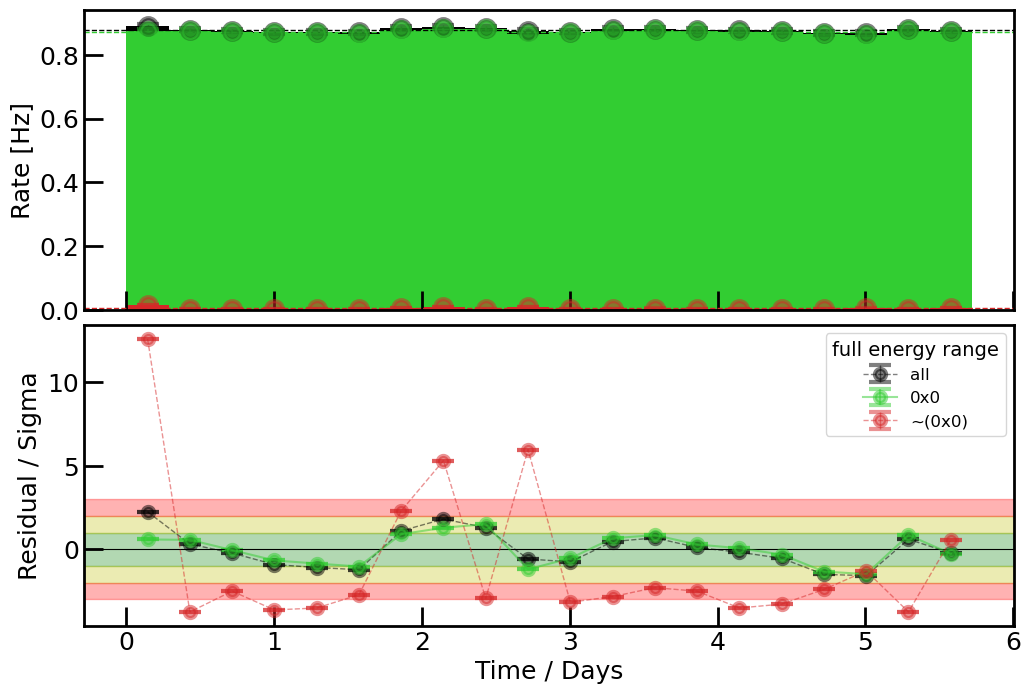

In [22]:
simple_rates(data=data, fout="overall_rates_flags_vs_time.png", title="full energy range", plot_espc=False)

/tmp/ipykernel_38009/4282955835.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


sample name = 2025-10-07_LowRad_PMTBases_Resistors_Glue
m.group(1)='1460.8'


/tmp/ipykernel_38009/1419719812.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


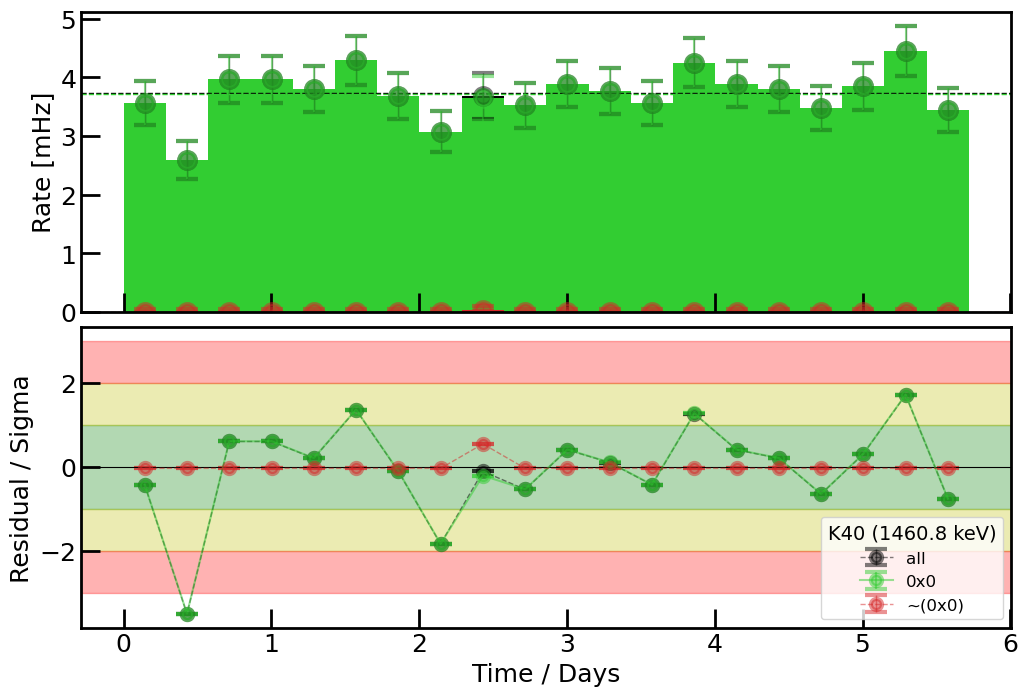

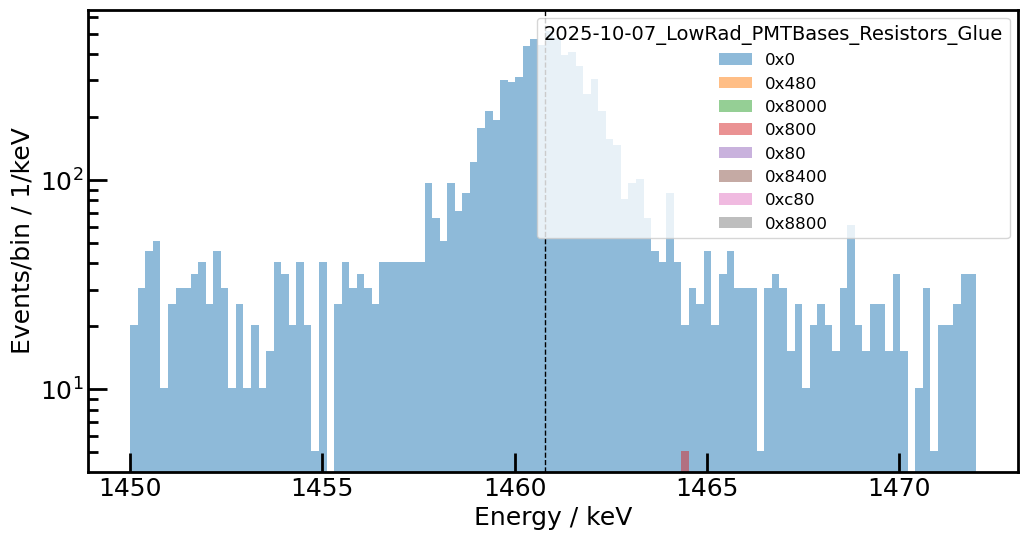

In [23]:
simple_rates(data=data, Erange=(1450,1472), fout="K40_1460.8keV.png", title="K40 (1460.8 keV)", plot_espc=True)

/tmp/ipykernel_38009/4282955835.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


sample name = 2025-10-07_LowRad_PMTBases_Resistors_Glue
m.group(1)='185.7'


/tmp/ipykernel_38009/1419719812.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


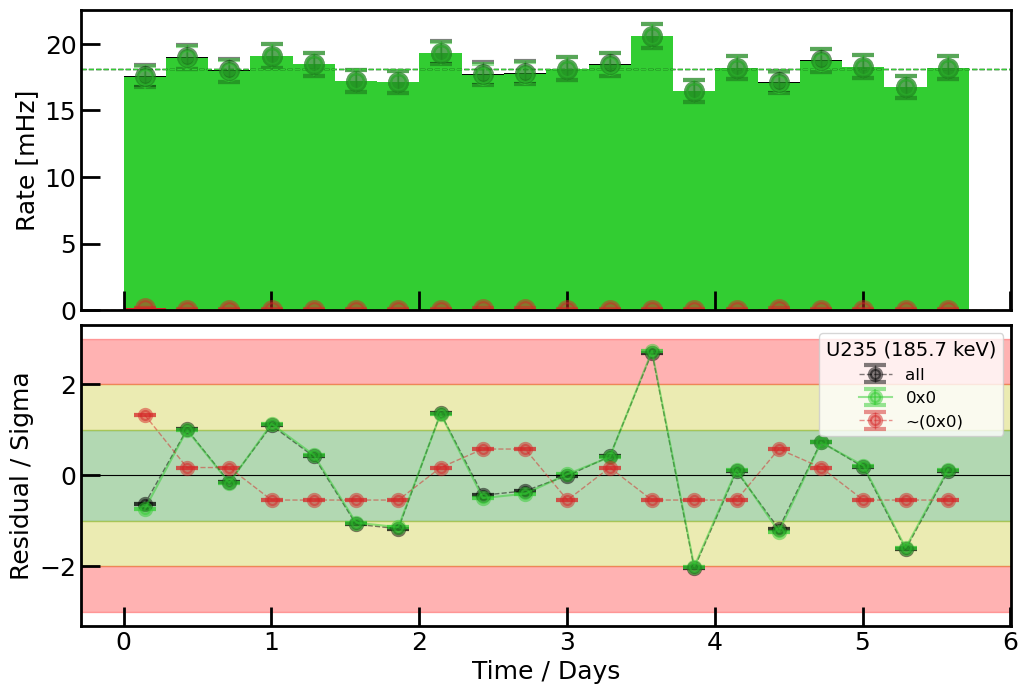

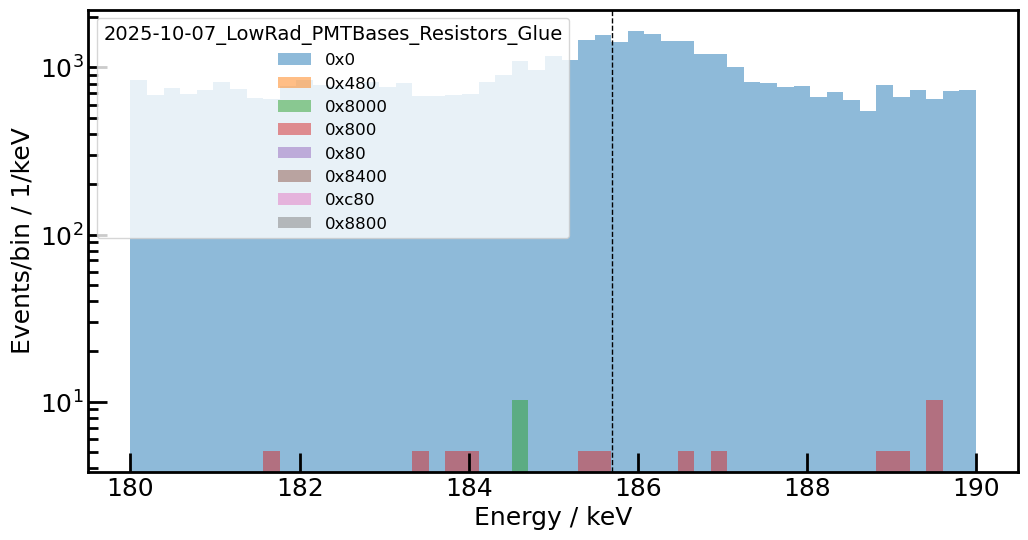

In [24]:
#simple_rates(data=data, ADCrange=(910,955), fout="U235_185.7keV.png", title="U235 (185.7 keV)", plot_espc=True)
simple_rates(data=data, Erange=(180,190), fout="U235_185.7keV.png", title="U235 (185.7 keV)", plot_espc=True)

/tmp/ipykernel_38009/4282955835.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


sample name = 2025-10-07_LowRad_PMTBases_Resistors_Glue
m.group(1)='511.0'


/tmp/ipykernel_38009/1419719812.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


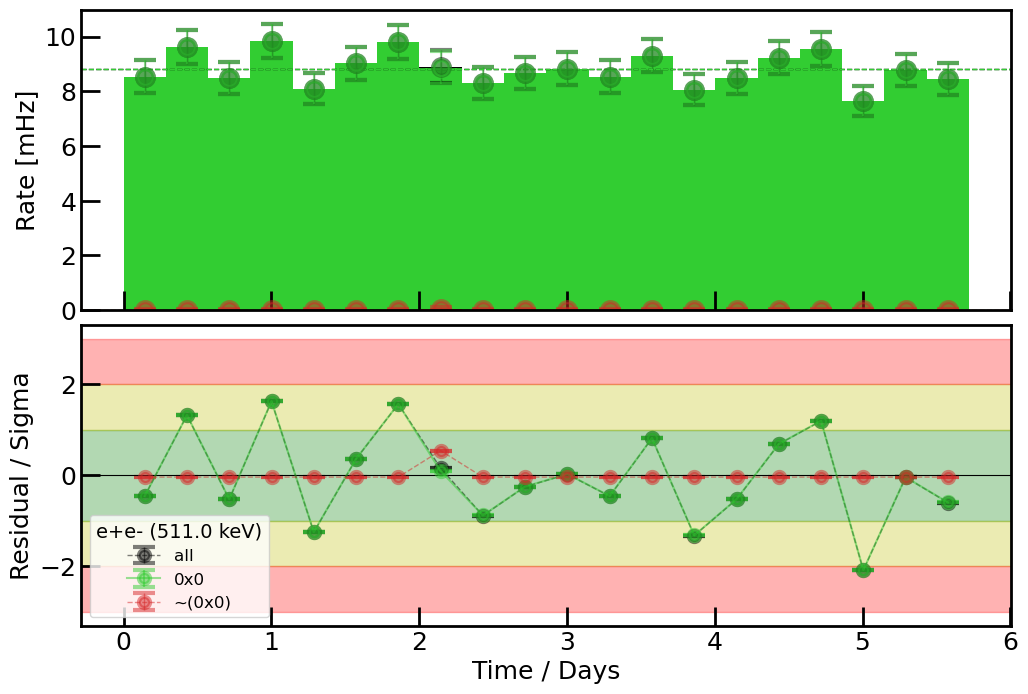

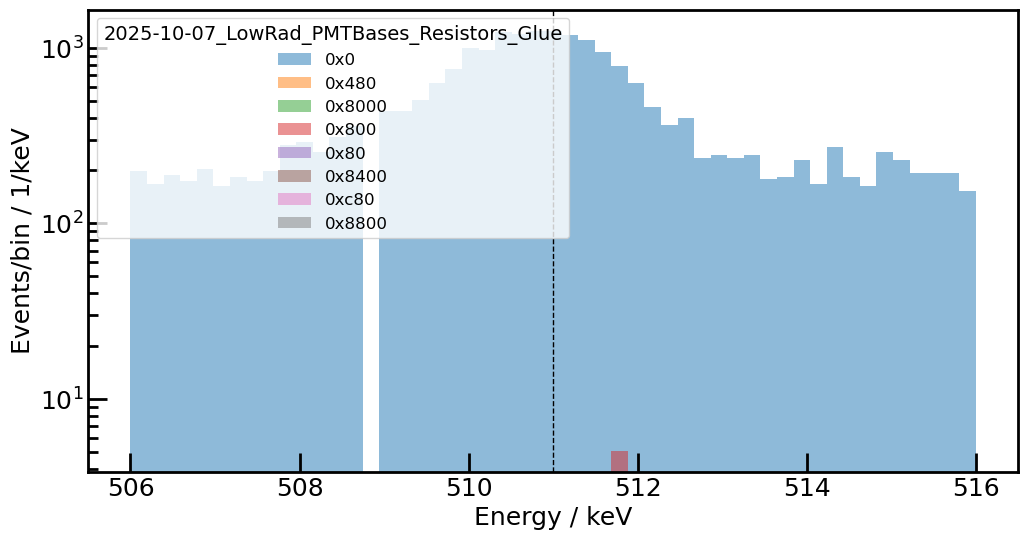

In [25]:
simple_rates(data=data, Erange=(506,516), fout="eeann_511.0keV.png", title="e+e- (511.0 keV)", plot_espc=True)

/tmp/ipykernel_38009/4282955835.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


sample name = 2025-10-07_LowRad_PMTBases_Resistors_Glue
Cannot match. e=AttributeError("'NoneType' object has no attribute 'group'")


/tmp/ipykernel_38009/1419719812.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


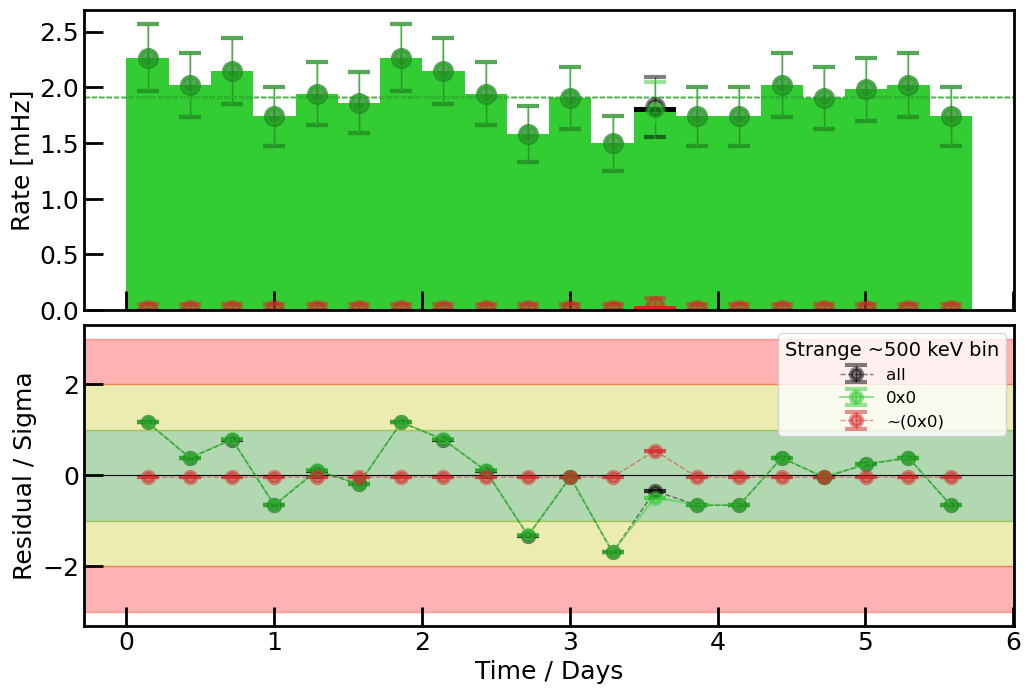

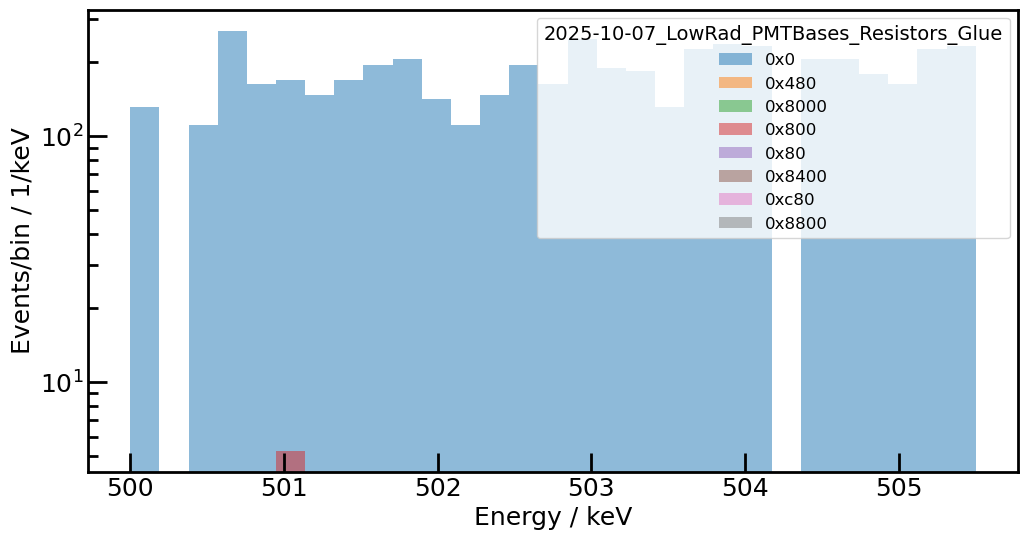

In [26]:
simple_rates(data=data, Erange=(500,505.5), fout="strange_500keV_bin.png", title="Strange ~500 keV bin", plot_espc=True)

/tmp/ipykernel_38009/4282955835.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


sample name = 2025-10-07_LowRad_PMTBases_Resistors_Glue
m.group(1)='238.6'


/tmp/ipykernel_38009/1419719812.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


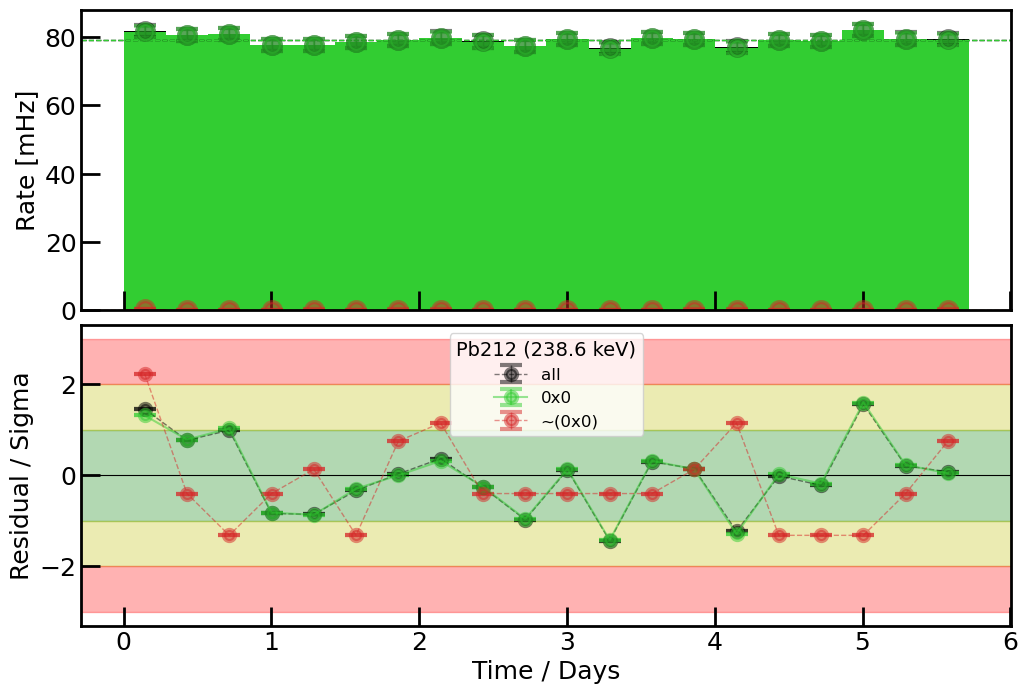

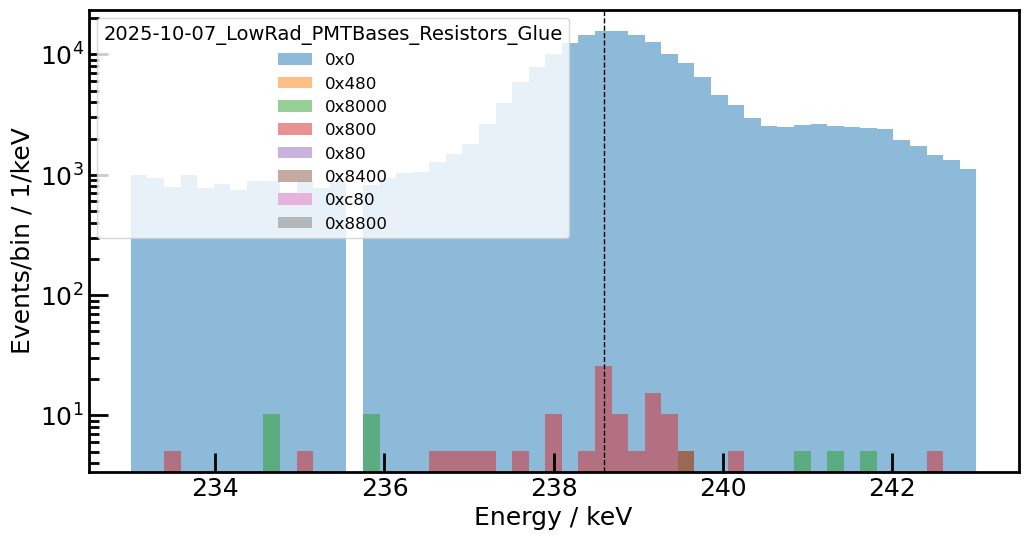

In [27]:
#simple_rates(data=data, ADCrange=(1180,1220), fout="Pb212_238.6keV.png", title="Pb212 (238.6 keV)", plot_espc=True)
simple_rates(data=data, Erange=(233,243), fout="Pb212_238.6keV.png", title="Pb212 (238.6 keV)", plot_espc=True)

/tmp/ipykernel_38009/4282955835.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


sample name = 2025-10-07_LowRad_PMTBases_Resistors_Glue
m.group(1)='351.9'


/tmp/ipykernel_38009/1419719812.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


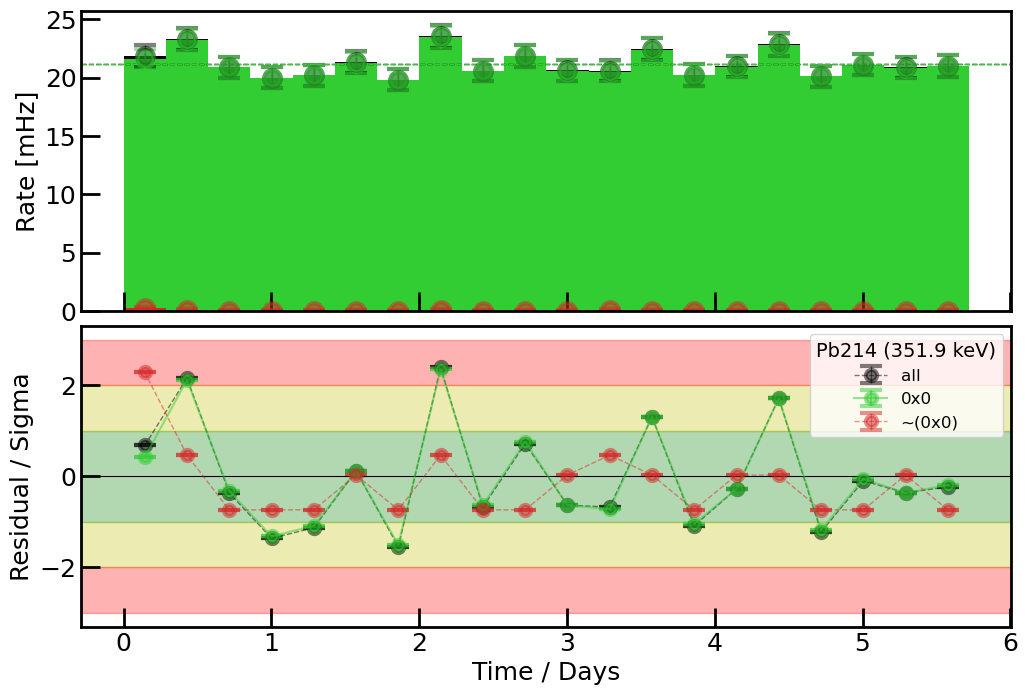

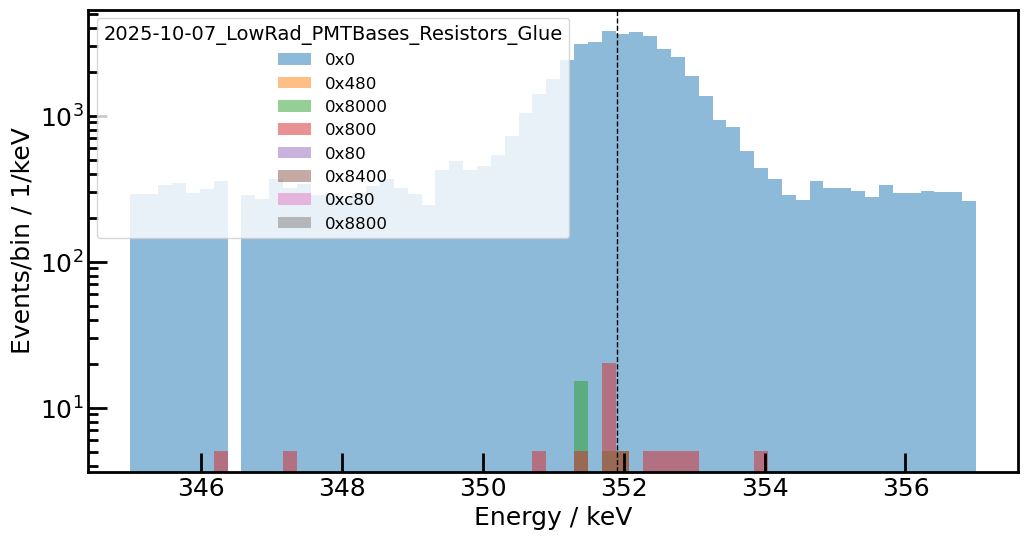

In [28]:
simple_rates(data=data, Erange=(345,357), fout="Pb214_351.9keV.png", title="Pb214 (351.9 keV)", plot_espc=True)

/tmp/ipykernel_38009/4282955835.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


sample name = 2025-10-07_LowRad_PMTBases_Resistors_Glue
m.group(1)='609.3'


/tmp/ipykernel_38009/1419719812.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


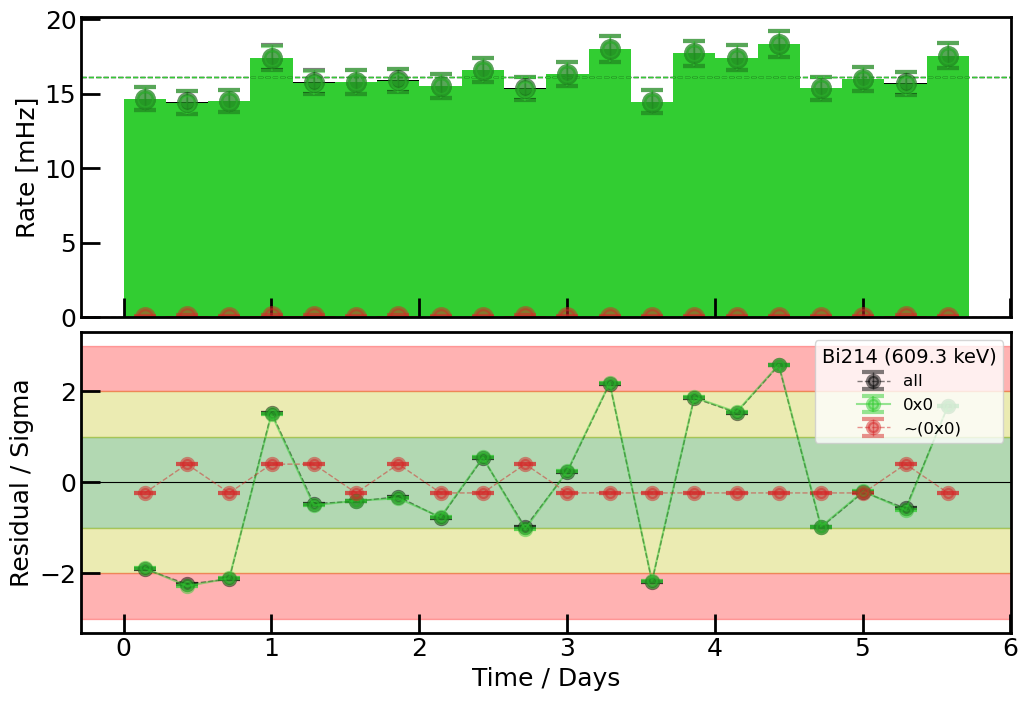

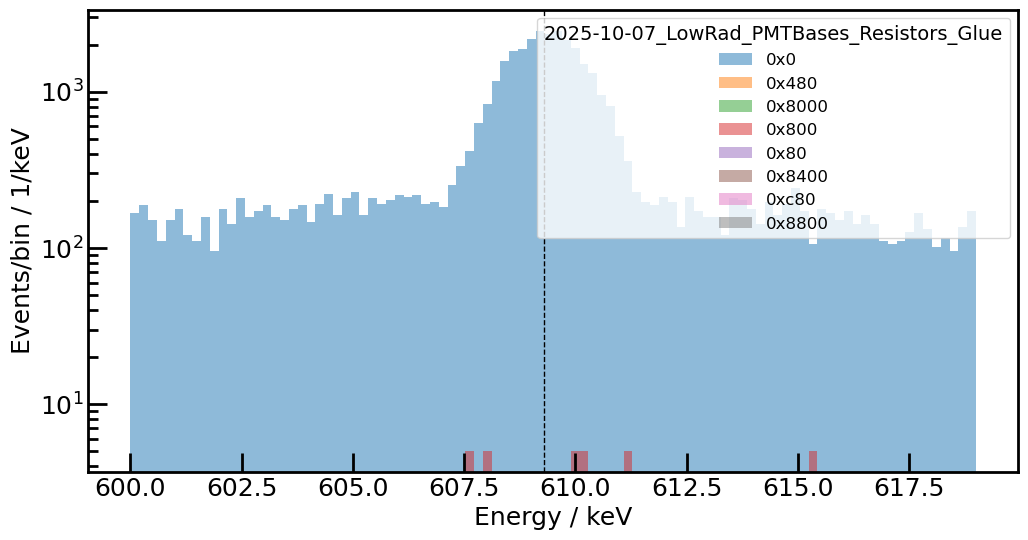

In [29]:
simple_rates(data=data, Erange=(600,619), fout="Bi214_609.3keV.png", title="Bi214 (609.3 keV)", plot_espc=True)

/tmp/ipykernel_38009/4282955835.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


sample name = 2025-10-07_LowRad_PMTBases_Resistors_Glue
m.group(1)='1120.3'


/tmp/ipykernel_38009/1419719812.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


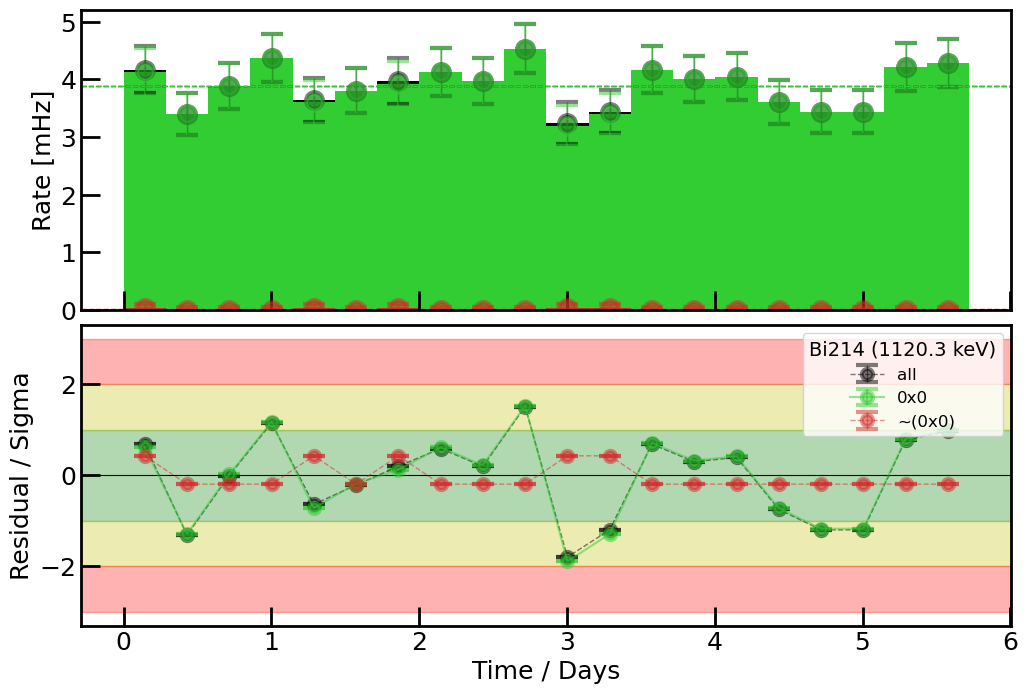

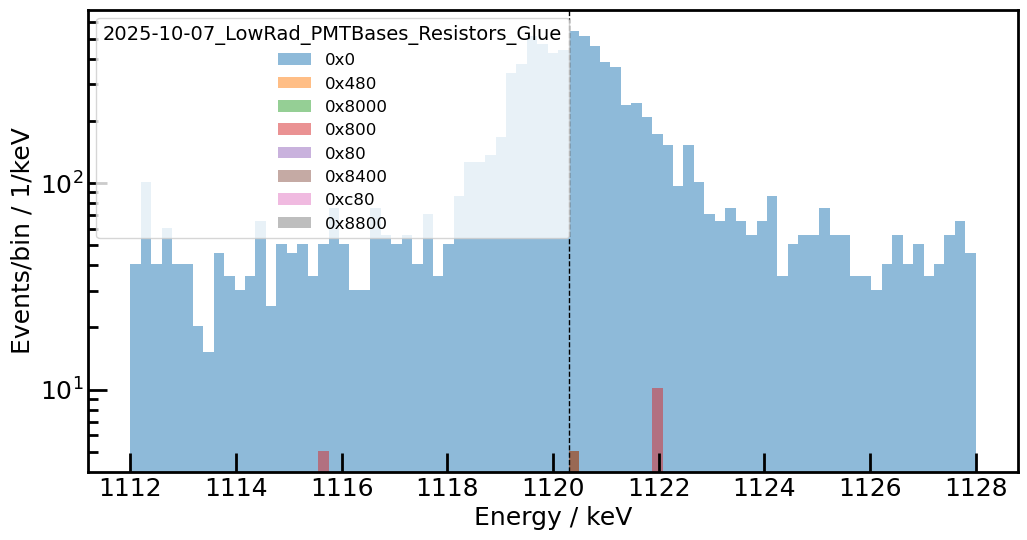

In [30]:
simple_rates(data=data, Erange=(1112,1128), fout="Bi214_1120.3keV.png", title="Bi214 (1120.3 keV)", plot_espc=True)

/tmp/ipykernel_38009/4282955835.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


sample name = 2025-10-07_LowRad_PMTBases_Resistors_Glue
m.group(1)='1332.5'


/tmp/ipykernel_38009/1419719812.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


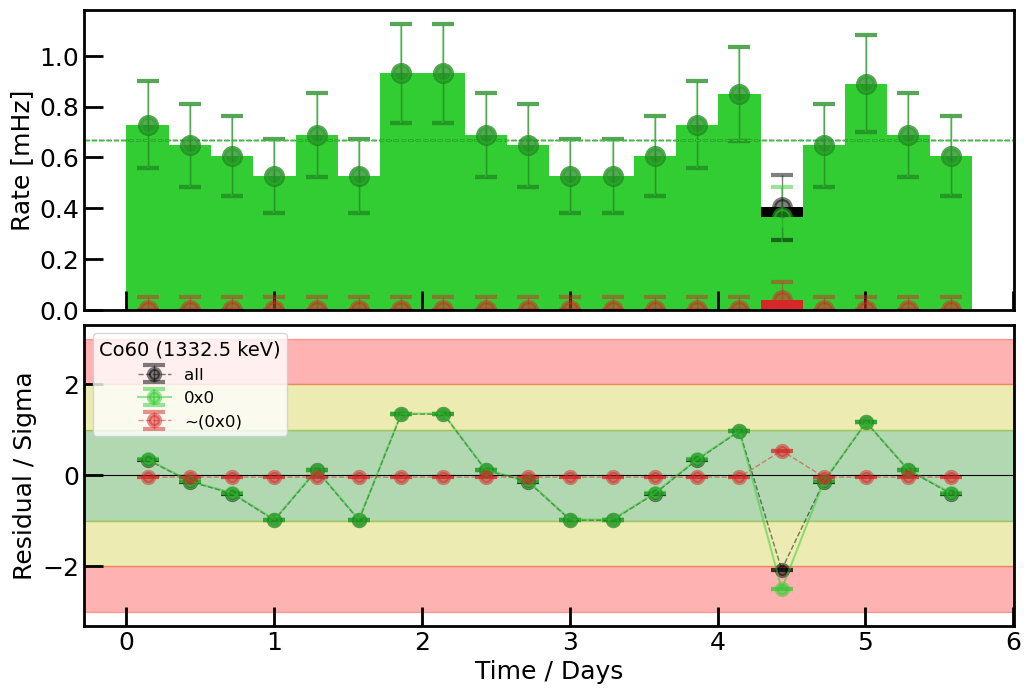

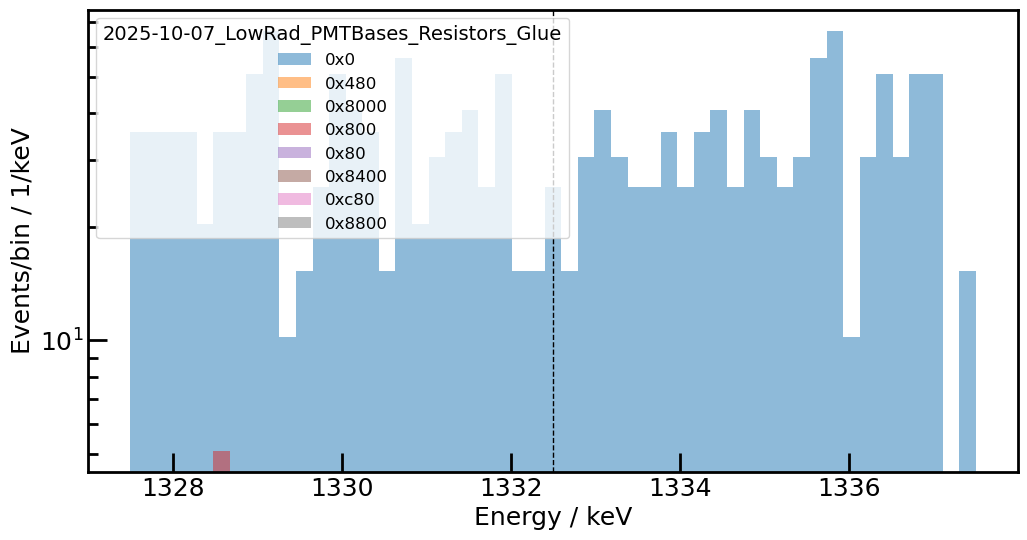

In [31]:
simple_rates(data=data, Erange=(1327.5,1337.5), fout="Co60_1332.5keV.png", title="Co60 (1332.5 keV)", plot_espc=True)

/tmp/ipykernel_38009/4282955835.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


sample name = 2025-10-07_LowRad_PMTBases_Resistors_Glue
m.group(1)='2614.5'


/tmp/ipykernel_38009/1419719812.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


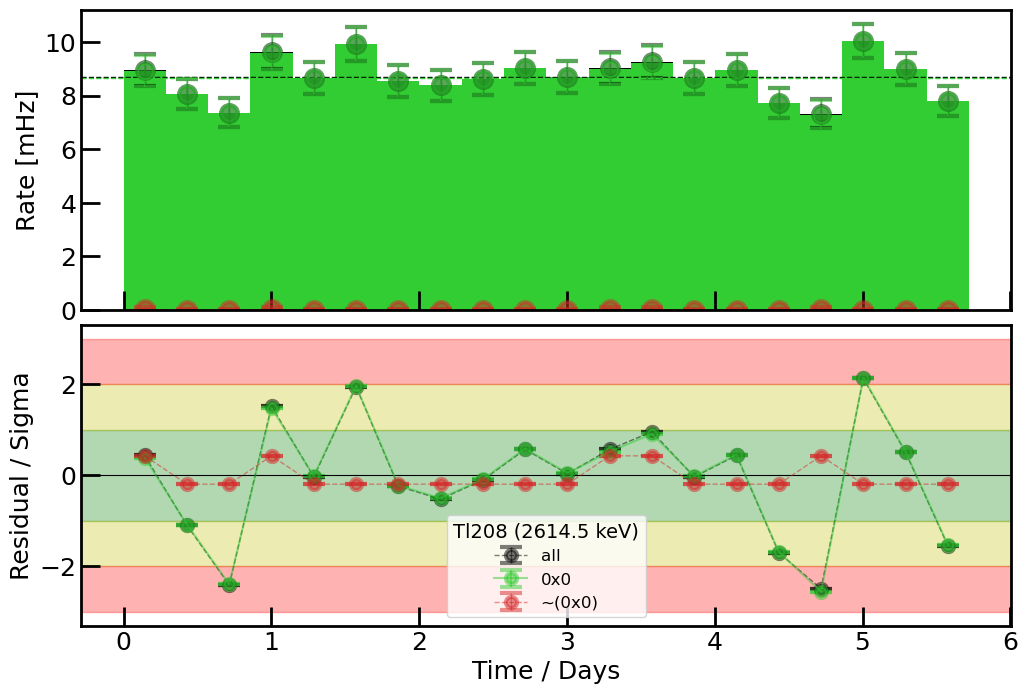

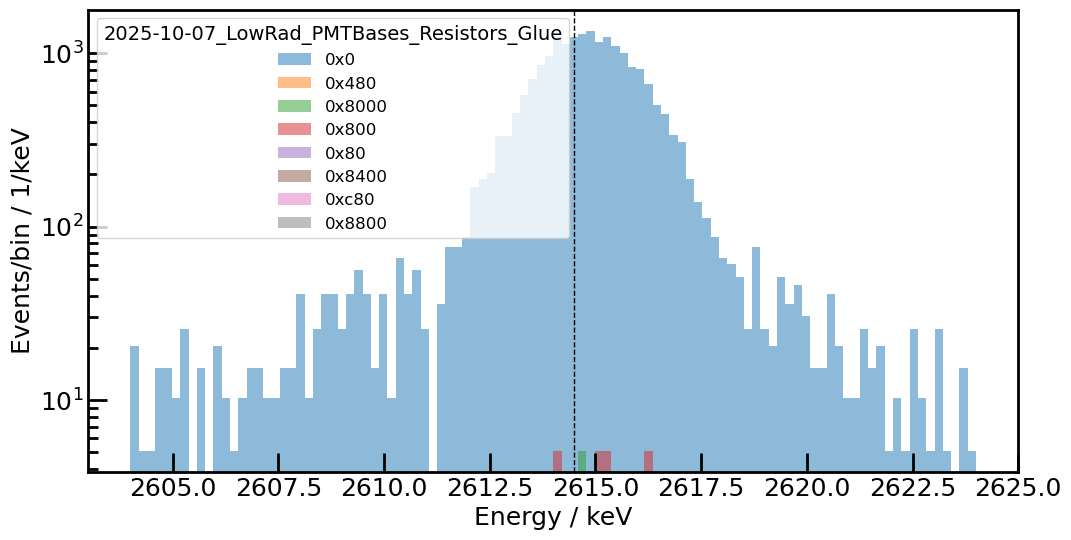

In [32]:
#simple_rates(data=data, ADCrange=(13000,13250), fout="Tl208_2614.5keV.png", title="Tl208 (2614.5 keV)", plot_espc=True)
simple_rates(data=data, Erange=(2604,2624), fout="Tl208_2614.5keV.png", title="Tl208 (2614.5 keV)", plot_espc=True)

/tmp/ipykernel_38009/4282955835.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


sample name = 2025-10-07_LowRad_PMTBases_Resistors_Glue
m.group(1)='1001.0'


/tmp/ipykernel_38009/1419719812.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


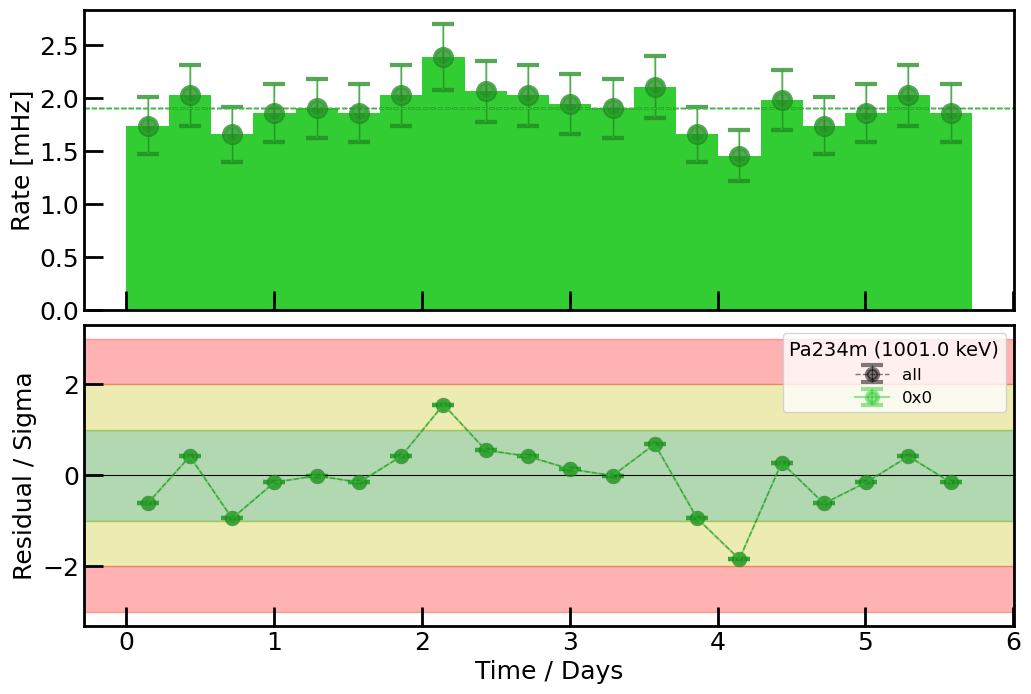

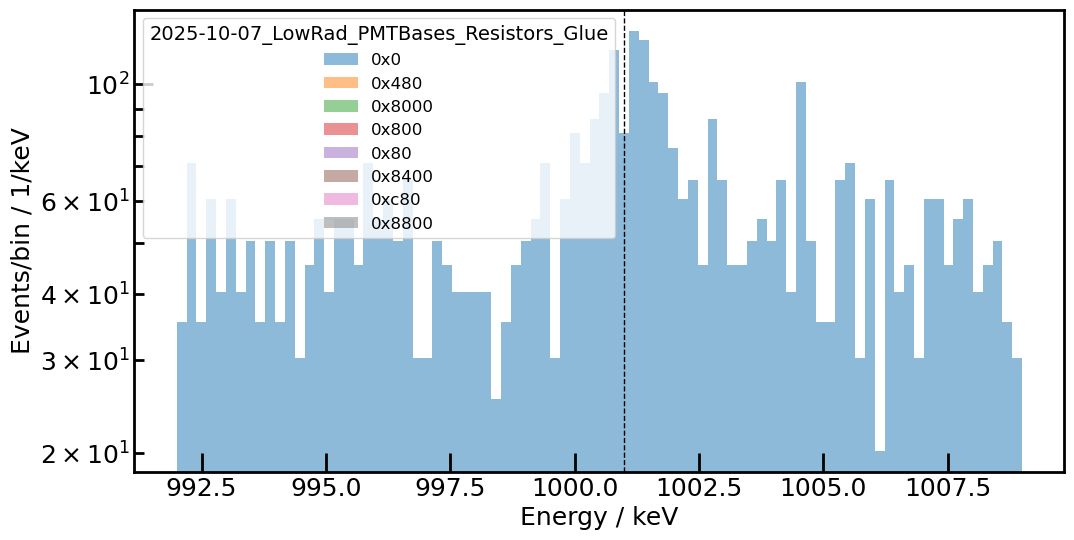

In [33]:
#simple_rates(data=data, ADCrange=(5010,5060), fout="Pa234m_1001.0keV.png", title="Pa234m (1001.0 keV)", plot_espc=True)
simple_rates(data=data, Erange=(992,1009), fout="Pa234m_1001.0keV.png", title="Pa234m (1001.0 keV)", plot_espc=True)

## energy spectra vs flags

sample name = 2025-10-07_LowRad_PMTBases_Resistors_Glue
0x0 (0) -> n_events=432765
0x480 (1152) -> n_events=1685
0x8000 (32768) -> n_events=706
0x800 (2048) -> n_events=419
0x80 (128) -> n_events=71
0x8400 (33792) -> n_events=8
0xc80 (3200) -> n_events=1
0x8800 (34816) -> n_events=1


/tmp/ipykernel_38009/1419719812.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


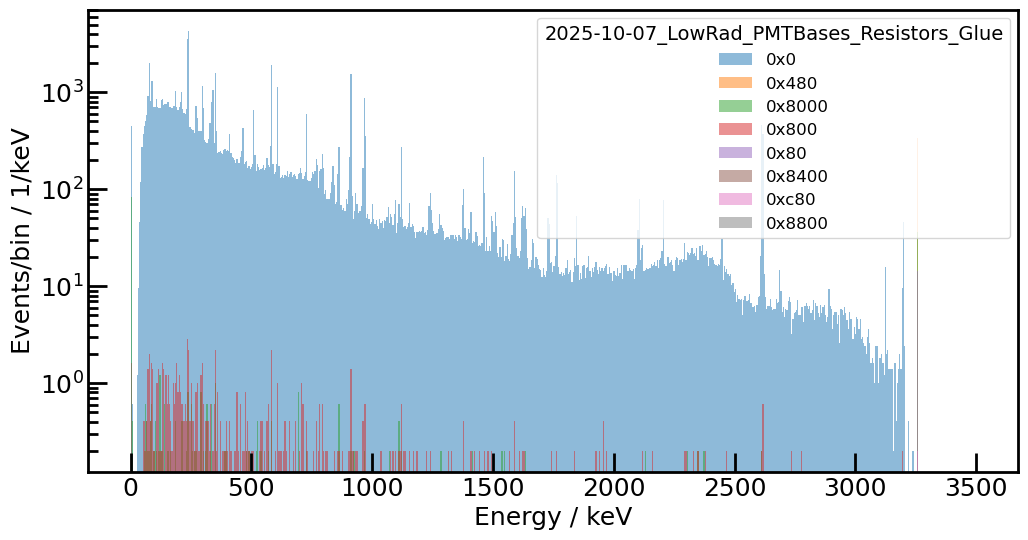

In [34]:
sample_name = get_sample_name()
sn_short= get_short_name(name=sample_name)
plot_hist_flags(data=data, erange=(0,3500), n_drawonly=-1, verbose=True, 
                alpha=0.5, 
                sumbins=25,
                title=sample_name, 
                fout="spectrum_fullErange.png",
               )

/tmp/ipykernel_38009/1419719812.py:53: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(fout)
/tmp/ipykernel_38009/1419719812.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/home/sebastian/miniconda3/envs/dummy39/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/sebastian/miniconda3/envs/dummy39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


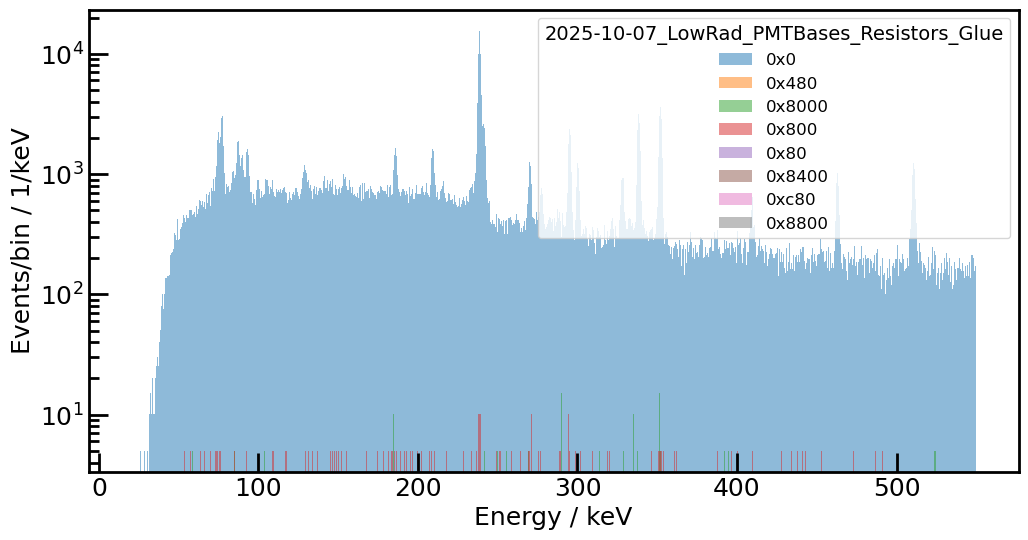

In [35]:
plot_hist_flags(data=data, erange=(20,550), n_drawonly=-1, verbose=False, 
                alpha=0.5, 
                sumbins=1,
                xaxis="keV",
                title=sample_name, 
                fout="20kev-550keV.png",
               )